# Import packages


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score

In [ ]:
#added imports
import re
import string
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
!pip install text_preprocessing


# Load Data

In [ ]:
# this is only sample data, full data is not available here
df = pd.read_csv("https://drive.google.com/uc?export=download&id=15gnHRjeffGJfxXnvwGYrBAlQNUsdaySV", index_col='id')

In [ ]:
all_labels = df.label.unique()
label_dict = {}
for index, possible_label in enumerate(all_labels):
    label_dict[possible_label] = index
pred_dict = dict(zip(label_dict.values(),label_dict.keys()))
pred_dict

{0: 'iot_cleaning',
 1: 'general_negate',
 2: 'datetime_convert',
 3: 'lists_query',
 4: 'email_query',
 5: 'play_radio',
 6: 'general_affirm',
 7: 'iot_hue_lightdim',
 8: 'music_query',
 9: 'iot_wemo_off',
 10: 'transport_traffic',
 11: 'recommendation_locations',
 12: 'calendar_remove',
 13: 'recommendation_movies',
 14: 'social_query',
 15: 'iot_wemo_on',
 16: 'play_podcasts',
 17: 'general_quirky',
 18: 'alarm_remove',
 19: 'news_query',
 20: 'alarm_query',
 21: 'datetime_query',
 22: 'iot_coffee',
 23: 'play_music',
 24: 'cooking_recipe',
 25: 'play_game',
 26: 'lists_remove',
 27: 'general_explain',
 28: 'takeaway_query',
 29: 'iot_hue_lightoff',
 30: 'qa_stock',
 31: 'general_repeat',
 32: 'qa_currency',
 33: 'transport_taxi',
 34: 'play_audiobook',
 35: 'social_post',
 36: 'transport_query',
 37: 'alarm_set',
 38: 'music_likeness',
 39: 'recommendation_events',
 40: 'general_joke',
 41: 'calendar_query',
 42: 'lists_createoradd',
 43: 'iot_hue_lightchange',
 44: 'iot_hue_lightu

# Preprocessing

In [ ]:
def clean_text(text):
    """ clean the text by removing special characters, punctuations, etc. """
    text = text.lower()
    remove_xx_seq  = re.compile('xx+')
    replace_by_space = re.compile('[/(){}\[\]\|@,;]')
    text = re.sub(remove_xx_seq, ' ', text)
    text = re.sub(replace_by_space, ' ', text)
    return text.strip()

def preprocess_corpus(in_df, column='text'):
    out_df = in_df.copy()
    out_df[column] = out_df[column].apply(clean_text)
    return out_df

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score

def print_ami_score(val, pred):
    # val is validation dataset
    # pred is the predictions 
    ari = adjusted_rand_score(val, pred)
    ami = adjusted_mutual_info_score(val, pred, average_method='arithmetic')

    print("ARI: {}".format(ari))
    print("AMI: {}".format(ami))

In [ ]:
import text_preprocessing 
#normalize to lowercase
def preprocess_text(in_df):
  ds_temp = in_df.copy()
  ds_temp = in_df['message'].apply(text_preprocessing.to_lower)
  #ds_temp = ds_temp.apply(text_preprocessing.expand_contraction)
  ds_temp = ds_temp.apply(text_preprocessing.remove_punctuation)
  #ds_temp = ds_temp.apply(text_preprocessing.remove_whitespace)
  in_df['message'] = ds_temp
  return in_df

def tokenize_text(in_df):
  df_temp = in_df.copy()
  df_temp = preprocess_text(df_temp)
  ds_temp = df_temp['message'].map(str)
  ds_temp = ds_temp.apply(text_preprocessing.tokenize_word)
  ds_temp = ds_temp.apply(text_preprocessing.substitute_token)
  ds_temp = ds_temp.apply(text_preprocessing.remove_stopword)
  ds_temp = ds_temp.apply(text_preprocessing.stem_word)
  for x in ds_temp.index:
    ds_temp[x] = str(' '.join(ds_temp[x]))
  df_temp['message'] = ds_temp
  #df_temp= df_temp.drop_duplicates(subset=['message', 'label'])
  return df_temp

In [ ]:
def plot_label_vs_doc(df):
  df.label.value_counts().plot( title='No. of Labels vs Number of Documents', figsize=(12,5))
plot_label_vs_doc(df)

# SL Model


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing

def compute_tfidf(corpus, stop_words='english', ngram_range=(1, 1), max_features=None):
    vectorizer = TfidfVectorizer(input='content', stop_words=stop_words, ngram_range=ngram_range, min_df=3, max_df=0.9, max_features=max_features)
    X = vectorizer.fit_transform(corpus)
    print('done TF_IDF')
    return X, vectorizer

def encode_labels(labels):
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(labels)
    print('done Label Encoder')
    return label_encoder

In [ ]:
X = df['message']
y = df['label']

# Create tfidf features from the text
STOP_WORDS    = 'english'
NGRAM_RANGE   = (1, 1)
MAX_FEATURES  = None

X, vectorizer = compute_tfidf(X, STOP_WORDS, NGRAM_RANGE, MAX_FEATURES)
#X, vectorizer = compute_tfidf(df_clean['message'])

# Encode the labels
label_encoder = encode_labels(all_labels)
y = label_encoder.transform(y)

done TF_IDF
done Label Encoder


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
print('Training set Shape: {}  | Test set Shape: {}'.format(X_train.shape, X_val.shape))

Training set Shape: (7107, 1309)  | Test set Shape: (1777, 1309)


## SL Models

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

#sl_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, n_jobs=-1, verbose=0)
#sl_model = LogisticRegression(penalty='l2', max_iter=500)
sl_model = MultinomialNB()

In [ ]:
sl_model = sl_model.fit(X_train, y_train)
sl_predictions = sl_model.predict(X_val)
metrics_report = classification_report(y_val, sl_predictions, target_names=all_labels)

print_ami_score(y_val,sl_predictions)
print(metrics_report)

ARI: 0.6159172329933718
AMI: 0.7430404562702752
                          precision    recall  f1-score   support

            iot_cleaning       0.89      0.79      0.84        42
          general_negate       0.83      0.36      0.50        14
        datetime_convert       0.60      0.85      0.71        34
             lists_query       1.00      0.18      0.31        11
             email_query       0.67      0.73      0.70        11
              play_radio       0.84      0.70      0.76        30
          general_affirm       0.83      0.24      0.37        42
        iot_hue_lightdim       0.64      1.00      0.78        28
             music_query       0.66      0.66      0.66        29
            iot_wemo_off       0.79      0.75      0.77        20
       transport_traffic       1.00      0.64      0.78        14
recommendation_locations       0.65      0.94      0.77        34
         calendar_remove       0.91      0.56      0.69        18
   recommendation_movies   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Ktrain Prep

In [ ]:
!pip install --upgrade pip -q
!pip install -q ktrain

In [ ]:
!pip install transformers

from sklearn import preprocessing
import tensorflow as tf
#from transformers import glue_convert_examples_to_features, InputExample
from tqdm import tqdm
import ktrain
from ktrain import text

In [ ]:
# Preprocess the corpus, i.e. clean the text
print('Cleaning the text...', end='')
# best score with ktrain, bert 12 epochs, lr 3e-5, .91 accuracy .89 ami, after clean
df_1 = preprocess_corpus(df, column='message')
#df_1 = df.copy()
print('done.')

Cleaning the text...done.


In [ ]:
df_1.sample(3)
print("Dataframe Shape:" , df_1.shape )

,message,label
id,,
6066,remove my shopping list,lists_remove
9396,i'd like a train ticket to this location,transport_query
3211,yeap you've got your understanding right.,general_affirm


Dataframe Shape: (8884, 2)


In [ ]:
list1 = df_1['message'].str.split(' ', expand=True).stack().unique().tolist()
print('Total Unique Words:', len(list1))

Total Unique Words: 4273


In [ ]:
X = df_1['message']
y = df_1['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

X_train = X_train.to_list()
y_train = y_train.to_list()
X_test = X_test.to_list()
y_test = y_test.to_list()

# KTrain Loading Models

In [ ]:
MODEL_NAME = 'roberta-base'
#MODEL_NAME = 'xlnet-large-cased'
#MODEL_NAME = 'roberta-large'

t = text.Transformer(MODEL_NAME,)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_test, y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 7
	95percentile : 12
	99percentile : 15


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:738: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  "class_names argument was ignored, as they were extracted from string labels in dataset"


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 7
	95percentile : 12
	99percentile : 16


In [ ]:
k_model = t.get_classifier()
k_learner = ktrain.get_learner(k_model, train_data=trn, val_data=val, batch_size=12)

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
592/592 [==============================] - 197s 331ms/step - loss: 4.1573 - accuracy: 0.0156
Epoch 2/1024
592/592 [==============================] - 198s 335ms/step - loss: 5.4357 - accuracy: 0.1123
Epoch 3/1024
592/592 [==============================] - 5s 8ms/step - loss: 44.3410 - accuracy: 0.0148


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


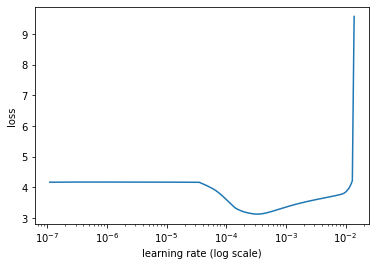

In [ ]:
# find good learning rate
k_learner.lr_find()             # briefly simulate training to find good learning rate
k_learner.lr_plot()             # visually identify best learning rate

In [ ]:
# run this first, to get to a good overall accuracy before running autofit
k_history = k_learner.fit_onecycle(lr=3e-5, epochs=8)



begin training using onecycle policy with max lr of 3e-05...
Epoch 1/8
593/593 [==============================] - 218s 340ms/step - loss: 3.5228 - accuracy: 0.3117 - val_loss: 2.1347 - val_accuracy: 0.7029
Epoch 2/8
593/593 [==============================] - 202s 339ms/step - loss: 1.5467 - accuracy: 0.7865 - val_loss: 0.7957 - val_accuracy: 0.8616
Epoch 3/8
593/593 [==============================] - 202s 339ms/step - loss: 0.6440 - accuracy: 0.8915 - val_loss: 0.4685 - val_accuracy: 0.8931
Epoch 4/8
593/593 [==============================] - 202s 339ms/step - loss: 0.3543 - accuracy: 0.9305 - val_loss: 0.4574 - val_accuracy: 0.8897
Epoch 5/8
593/593 [==============================] - 202s 339ms/step - loss: 0.2296 - accuracy: 0.9488 - val_loss: 0.4181 - val_accuracy: 0.8970
Epoch 6/8
593/593 [==============================] - 202s 339ms/step - loss: 0.1350 - accuracy: 0.9727 - val_loss: 0.3774 - val_accuracy: 0.9088
Epoch 7/8
593/593 [==============================] - 202s 339ms/ste

In [52]:
et_history = k_learner.autofit(3e-6)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 3e-06...
Epoch 1/1024
593/593 [==============================] - 203s 341ms/step - loss: 0.0353 - accuracy: 0.9966 - val_loss: 0.3740 - val_accuracy: 0.9167
Epoch 2/1024
593/593 [==============================] - 203s 340ms/step - loss: 0.0339 - accuracy: 0.9968 - val_loss: 0.3714 - val_accuracy: 0.9173
Epoch 3/1024
593/593 [==============================] - 204s 342ms/step - loss: 0.0313 - accuracy: 0.9968 - val_loss: 0.3681 - val_accuracy: 0.9178
Epoch 4/1024
593/593 [==============================] - 204s 341ms/step - loss: 0.0283 - accuracy: 0.9973 - val_loss: 0.3667 - val_accuracy: 0.9201
Epoch 5/1024
593/593 [==============================] - 204s 341ms/step - loss: 0.0255 - accuracy: 0.9976 - val_loss: 0.3762 - val_accuracy: 0.9178
Epoch 6/1024
593/593 [==============================] - ETA: 0s - loss: 0.02

In [53]:
k_learner.validate( val_data=val, class_names=label_dict)

                          precision    recall  f1-score   support

            iot_cleaning       0.97      0.97      0.97        31
          general_negate       0.95      1.00      0.97        18
        datetime_convert       0.94      0.97      0.96        34
             lists_query       0.86      0.92      0.89        13
             email_query       1.00      0.88      0.94        25
              play_radio       0.90      0.82      0.86        22
          general_affirm       0.81      0.81      0.81        32
        iot_hue_lightdim       0.97      1.00      0.98        28
             music_query       0.94      0.82      0.87        38
            iot_wemo_off       0.81      0.89      0.85        19
       transport_traffic       0.93      0.93      0.93        14
recommendation_locations       0.96      0.96      0.96        52
         calendar_remove       0.94      0.89      0.91        18
   recommendation_movies       0.87      0.87      0.87        31
         

array([[30,  0,  1, ...,  0,  0,  0],
       [ 0, 18,  0, ...,  0,  0,  0],
       [ 0,  0, 33, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 36,  0,  0],
       [ 0,  0,  0, ...,  0, 20,  0],
       [ 0,  0,  0, ...,  0,  0, 33]])

One of the best output from RoBERTa Large

```
                          precision    recall  f1-score   support

            iot_cleaning       1.00      0.94      0.97        33
          general_negate       0.94      1.00      0.97        15
        datetime_convert       0.92      0.97      0.94        34
             lists_query       0.93      1.00      0.96        13
             email_query       0.90      0.97      0.94        37
              play_radio       0.92      0.96      0.94        24
          general_affirm       0.76      0.76      0.76        34
        iot_hue_lightdim       0.90      1.00      0.95        27
             music_query       0.84      0.86      0.85        37
            iot_wemo_off       0.93      1.00      0.96        25
       transport_traffic       1.00      1.00      1.00        21
recommendation_locations       0.96      1.00      0.98        27
         calendar_remove       1.00      0.92      0.96        12
   recommendation_movies       0.79      1.00      0.88        26
            social_query       0.86      0.74      0.79        34
             iot_wemo_on       0.95      0.95      0.95        22
           play_podcasts       1.00      1.00      1.00        27
          general_quirky       1.00      0.94      0.97        31
            alarm_remove       1.00      1.00      1.00        28
              news_query       1.00      1.00      1.00        38
             alarm_query       1.00      1.00      1.00        30
          datetime_query       0.94      1.00      0.97        16
              iot_coffee       1.00      0.88      0.94        26
              play_music       1.00      1.00      1.00        35
          cooking_recipe       0.67      0.40      0.50        30
               play_game       0.95      1.00      0.97        38
            lists_remove       1.00      1.00      1.00        27
         general_explain       1.00      1.00      1.00        35
          takeaway_query       0.87      0.97      0.92        34
        iot_hue_lightoff       1.00      1.00      1.00        21
                qa_stock       0.96      0.89      0.93        28
          general_repeat       0.83      0.83      0.83         6
             qa_currency       1.00      0.88      0.93        32
          transport_taxi       0.80      1.00      0.89         8
          play_audiobook       1.00      0.92      0.96        13
             social_post       0.91      0.94      0.93        33
         transport_query       0.96      0.79      0.87        29
               alarm_set       1.00      0.94      0.97        33
          music_likeness       1.00      0.87      0.93        31
   recommendation_events       0.94      0.97      0.95        32
            general_joke       0.64      0.82      0.72        11
          calendar_query       0.94      0.94      0.94        35
       lists_createoradd       0.92      0.83      0.87        29
     iot_hue_lightchange       1.00      0.96      0.98        24
         iot_hue_lightup       0.78      0.86      0.82        29
           qa_definition       0.84      0.84      0.84        31
        email_addcontact       0.89      0.94      0.91        33
          general_praise       0.94      0.97      0.95        30
         general_confirm       0.96      0.88      0.92        26
     general_commandstop       0.75      0.83      0.79        29
              qa_factoid       0.95      1.00      0.98        21
                qa_maths       1.00      0.94      0.97        34
       audio_volume_down       0.85      0.91      0.88        32
        transport_ticket       0.85      0.81      0.83        27
          takeaway_order       0.88      1.00      0.94        15
            calendar_set       0.97      0.91      0.94        35
        general_dontcare       0.91      0.91      0.91        32
           weather_query       0.90      0.87      0.88        30
          music_settings       0.91      0.94      0.92        31
         iot_hue_lighton       0.97      0.94      0.96        35
      email_querycontact       0.91      1.00      0.95        31
       audio_volume_mute       1.00      0.95      0.97        37
         email_sendemail       0.93      1.00      0.96        27
         audio_volume_up       0.94      1.00      0.97        31

                accuracy                           0.93      1777
               macro avg       0.92      0.93      0.92      1777
            weighted avg       0.93      0.93      0.92      1777
```



In [ ]:
predictor = ktrain.get_predictor(k_learner.model, t, batch_size=16)

In [55]:
k_val_pred = predictor.predict(X_test)

In [ ]:
print_ami_score(y_test, k_val_pred)



```
RoBERTa Large 8 epochs, 12 batch, 3e-5 lr + autolearn
Using AMI/ARI only due to course requirement


ARI: 0.8593258587669634
AMI: 0.9056984570415593

ARI: 0.8746683573781052
AMI: 0.9171656203748378
```



# Explain

In [ ]:
!pip install https://github.com/amaiya/eli5/archive/refs/heads/tfkeras_0_10_1.zip

In [58]:
predictor.explain('list all alarms', all_targets=True)